In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### System Dynamics Example

Referring to [The Mathematics of Infectious Diseases](https://epubs.siam.org/doi/10.1137/S0036144500371907) by Herbert W. Hethcote (2000), we recreate the functions that update the various populations.

In [2]:
# update the number of susceptible persons, which decreases as 
# the ratio of infectious persons rises
def deltaSusceptible(beta, pop_s, pop_i, pop_n):
    return -1 * beta * pop_i * pop_s / pop_n

# update the number of infected persons, which increases as
# the number of susceptible persons does and decreases as
# people are removed from the infectable population
def deltaInfected(beta, gamma, pop_s, pop_i, pop_n):
    return (beta * pop_i * pop_s / pop_n) - gamma * pop_i

# remove people from the pool of infectable persons, through
# death or immunity
def deltaRemoved(gamma, pop_i):
    return gamma * pop_i

Then, we recreate the update function

In [3]:
# update the model based on its current state
def step(beta, gamma, pop_s, pop_i, pop_r):
    
    # calculate the overall number of persons
    pop_n = pop_s + pop_i + pop_r
    
    # update each of the compartments
    changeInSusceptible = deltaSusceptible(beta, pop_i, pop_s, pop_n)
    changeInInfected = deltaInfected(beta, gamma, pop_s, pop_i, pop_n)
    changeInRemoved = deltaRemoved(gamma, pop_i)
    
    # return the updated numbers of persons in each compartment
    # ...which cannot be less than zero!
    return max(0, pop_s + changeInSusceptible), max(0, pop_i + changeInInfected), max(0, pop_r + changeInRemoved)

Now, let's see it in action!

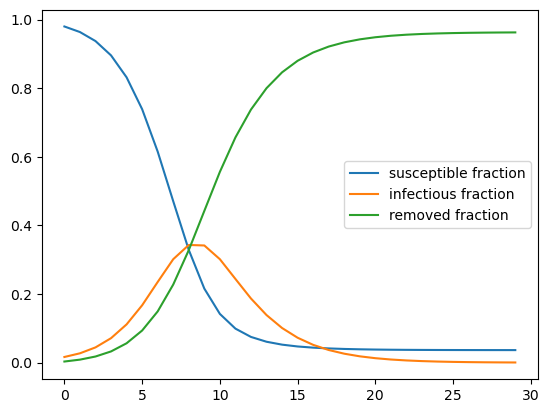

In [4]:
# set up the initial parameters of the model

# populate the compartments
susceptible = 99
infected = 1
removed = 0

total = susceptible + infected + removed # helper function

# set the disease parameters
beta = 1     # contact rate (ie how many contacts to transmit)
gamma = .333 # avg infectious period: 1/gamma = 3 days

# create some empty reporters to hold the results
s_frac = []
i_frac = []
r_frac = []

# for 30 steps, update the population
for i in range(30):
    susceptible, infected, removed = step(beta, gamma, susceptible, infected, removed)
    
    # remember to save any data you want to look at later as you go along!
    s_frac.append(susceptible/total)
    i_frac.append(infected/total)
    r_frac.append(removed/total)

# let's visualise the results!
plt.plot(s_frac, label="susceptible fraction")
plt.plot(i_frac, label="infectious fraction")
plt.plot(r_frac, label="removed fraction")
plt.legend()
plt.show()

How might we use this? Well, we can check how the timing of the epidemic peak might change!

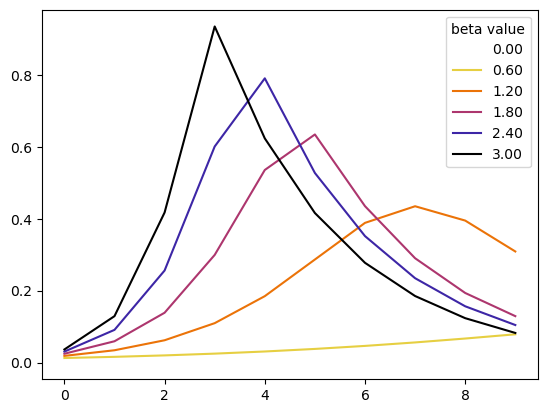

In [5]:
def run(beta, gamma, s, i, r, steps):
    t = s + i + r
    i_frac = []
    
    for x in range(steps):
        s, i, r = step(beta, gamma, s, i, r)
        i_frac.append(i / t)
    return i_frac

# the parameter space to search
space = np.linspace(0.0, 3.0, 6)

# a slightly nicer (but hacky) colourscheme
col = plt.cm.CMRmap_r(space / 3.)
index = 0

# iterate over the parameter space and run the different scenarios
for b in space:
    i_f = run(b, .333, 99, 1, 0, 10)
    plt.plot(i_f, label='{:.2f}'.format(b), color=col[index])
    index += 1

# visualise the results
plt.legend(title="beta value", loc="upper right")
plt.show()    

### Microsimulation Example

What if we want to look at individual characteristics, though?

Let's take the example of a non-communicable disease - something that develops over time, which is increasingly likely with age. We'll make a few assumptions:
* the likelihood of being diagnosed with the disease remains constant over time;
* the disease is equally common among men and women;
* the disease is not associated with any other comorbidities, such as heart health.

First, we'll create an object which holds the individuals being simulated.

In [6]:
# a class to help structure the simulation
class Person:
    alive = True
    age = 0
    sex = "F"
    ill = False
    heartFunction = 1.
    
    # set up a new Person
    def __init__(self, age, sex, ill=False, heartFunction=1.):
        self.age = age
        self.sex = sex
        self.ill = ill
        self.heartFunction = heartFunction
        
# create a random Person to use in the simulation
def generateRandomPerson():
    age = int(np.random.uniform(20, 80)) # age is uniform from 20 to 80
    sex = np.random.choice(["F", "M"])   # sex is randomly chosen
    return Person(age, sex)

def generateRandomPopulation(size):
    population = [] # create an empty holder for the population

    # create the random people
    for i in range(size):
        population.append(generateRandomPerson())
    
    return population

Let's write a function to help us look at our dummy population!

In [7]:
# helper function to print out the population by age and sex
def pop_report(pop):
    output = ""         # output string
    for p in pop:
        if not p.alive: # note if they're not alive
            output += "X"
        output += str(p.age) + p.sex + " "
    return output[:-1]  # leave off the final space to look nicer ;-)

# print out the population to see it!
population = generateRandomPopulation(20)
pop_report(population)

'44F 43M 73M 58M 51F 42M 77F 54F 39F 48F 26M 32F 47F 79F 53M 58M 70F 76F 61F 50F'

Ok, so what things might happen to this population? Let's assume that every year, they:
* age
* may die
* may develop the illness

Also, at the end of every year, some number of 20 year olds age up into the simulated population.

In [8]:
def step(pop, death_prob = .02, ill_prob = .03):
    
    # update each person!
    for p in pop:

        if not p.alive:
            continue # no need to keep checking!

        # they age a year
        p.age += 1
        
        # they may die
        myDeathProb = death_prob if not p.ill else death_prob * 2
        if np.random.rand() < myDeathProb:
            p.alive = False
            
        #...or get sick
        elif np.random.rand() < ill_prob:
            p.ill = True
    
    # here, we're adding new random people - but **they should be 20 years old**
    # because they're aging INTO the simulated population!
    newPeople = np.random.choice(3)
    for i in range(newPeople):
        newPerson = generateRandomPerson()  # generate them
        newPerson.age = 20                  # override their random age
        pop.append(newPerson)               # add them to the population
        
    return pop

So much of simulation is saving the right information and making it usable! Let's make a few more helper functions - to keep track of the status of everyone over time and to make it easier to visualise the results!

In [9]:
# for a given population, record their status in the designated container.
def pop_saver(pop, record):
    
    # get all of the new statuses
    output = []
    for p in pop: # save all of the statuses this step
        result = 0 if not p.alive else 1 if p.ill else 2
        output.append(result)
        
    # now store them in the container!
    if(len(record) == 0): # it may be a new container - set it up!
        record = pd.DataFrame([output])
    else:                 # it may need to be expanded - add it!
        newRec = pd.DataFrame([output])
        record = pd.concat([record, newRec], sort=False).fillna(3)
        
    # return the result
    return record

Let's add something to make it look nice!

In [10]:
# a helper function to identify the different statuses
def condition(v):
    return "Removed" if v == 0 else "Ill" if v == 1 else "Healthy" if v==2 else "n/a"

# a styler to make the output readable
def make_pretty(styler):
    styler.set_caption("Status over time")
    styler.format(condition)
    styler.background_gradient(axis=None, vmin=0, vmax=3, cmap="RdYlGn")
    return styler

In [11]:
record = "" # set up a new, empty container

population = generateRandomPopulation(20)

# iterate over ten years, updating the population accordingly
for i in range(10):
    population = step(population)
    record = pop_saver(population, record)

record.reset_index(inplace=True) # update the counter
record.loc[:,1:].style.pipe(make_pretty) # visualise the results!

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Removed,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
1,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Removed,Healthy,Removed,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Ill,Healthy,Healthy,Healthy,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
2,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Removed,Healthy,Removed,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Ill,Healthy,Healthy,Healthy,Healthy,Healthy,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
3,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Removed,Healthy,Removed,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Ill,Healthy,Healthy,Healthy,Healthy,Healthy,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
4,Removed,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Removed,Healthy,Removed,Healthy,Healthy,Healthy,Healthy,Healthy,Removed,Ill,Healthy,Ill,Healthy,Healthy,Healthy,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
5,Removed,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Removed,Healthy,Removed,Healthy,Ill,Healthy,Healthy,Healthy,Removed,Ill,Healthy,Ill,Healthy,Healthy,Healthy,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
6,Removed,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Removed,Healthy,Removed,Healthy,Ill,Healthy,Healthy,Healthy,Removed,Ill,Healthy,Ill,Healthy,Healthy,Healthy,Healthy,Healthy,n/a,n/a,n/a,n/a,n/a,n/a
7,Removed,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Removed,Healthy,Removed,Healthy,Ill,Healthy,Healthy,Healthy,Removed,Removed,Healthy,Ill,Healthy,Healthy,Healthy,Healthy,Ill,Healthy,Healthy,n/a,n/a,n/a,n/a
8,Removed,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Removed,Healthy,Removed,Healthy,Ill,Healthy,Healthy,Healthy,Removed,Removed,Healthy,Ill,Healthy,Healthy,Healthy,Healthy,Ill,Healthy,Healthy,Healthy,Healthy,n/a,n/a
9,Removed,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Removed,Healthy,Removed,Healthy,Ill,Healthy,Healthy,Healthy,Removed,Removed,Healthy,Ill,Healthy,Healthy,Healthy,Healthy,Ill,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy


### Agent-Based Modelling Example

Let's take an example of how a disease might spread over a network!

In [12]:
import networkx as nx

We create a new set of Persons, and connect them to one another. We create some helper functions to look at their health!

In [13]:
def generateRandomConnectedPopulation(size):
    population = generateRandomPopulation(size)
    contactNetwork = nx.Graph()
    
    for p in population:
        # Add the person to the contact network
        myLabel = "Dead" if not p.alive else "Ill" if p.ill else "Healthy"
        contactNetwork.add_node(p, label=(myLabel))
        for n in contactNetwork.nodes:
            if n is not p and np.random.rand() < .25:
                contactNetwork.add_edge(p, n)

    pos = nx.spring_layout(contactNetwork) # save this to show the same layout every time
    
    return population, contactNetwork, pos

def visualiseGraph(contactNetwork, population, pos=False):
    # Get positions
    if not pos:
        pos = nx.spring_layout(contactNetwork)

    subax1 = plt.subplot(111)
    

    colorByAttribute = {"Dead": "black", "Ill":"red", "Healthy":"green"}
    labels = ["Dead" if not p.alive else "Ill" if p.ill else "Healthy" for p in population]
    nodeColors = [colorByAttribute[x] for x in labels]
    nx.draw_networkx(contactNetwork, pos, with_labels=False, node_color=nodeColors)#, labels)#, font_weight='bold')
    plt.tight_layout()
    plt.show()

We create a step function, which helps the Person agents in the population to update their status as a result of their internal processes and their environment. Note that a Person who is sick will interact with their neighbours, potentially infecting them - but if a Person dies, they can no longer be a vector for disease in their social network.

In [14]:
def step(population, contactNetwork, spread_prob = .3, recover_prob = .3, death_prob = .01):
    for p in population:

        if not p.alive: # don't update dead people
            continue
        
        # if they've died, stop spreading the disease!
        elif p.alive and np.random.rand() < death_prob:
            p.alive = False
            continue
            
        # sick people spread the illness
        if p.ill:
            
            # potentially infect all neighbors
            for n in contactNetwork.neighbors(p):
                if n.alive and np.random.rand() < spread_prob:
                    n.ill = True
            
            # potentially recover
            if np.random.rand() < recover_prob:
                n.ill = False

Let's see an example of what a very small population looks like when we create a population, visualise it...

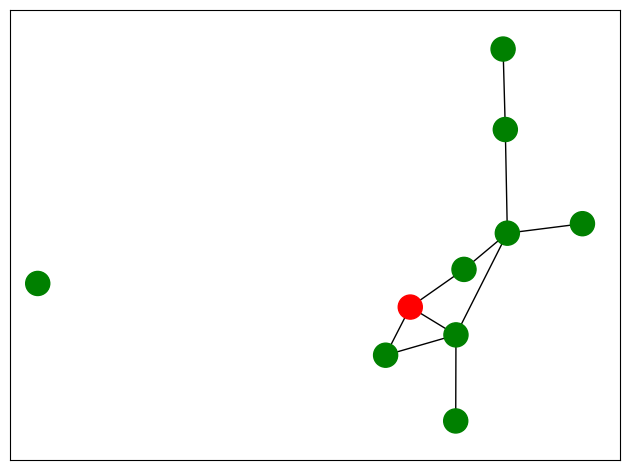

In [15]:
population, contactNetwork, pos = generateRandomConnectedPopulation(10)
population[0].ill = True
visualiseGraph(contactNetwork, population, pos)

...and update it!

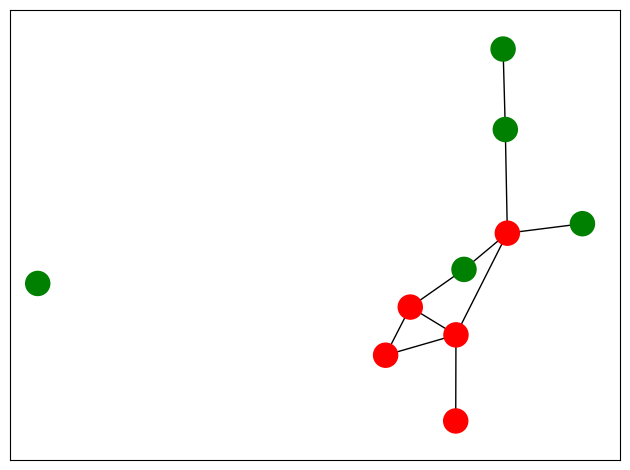

In [16]:
for i in range(3): # advance the simulation 3 time steps!
    step(population, contactNetwork)
visualiseGraph(contactNetwork, population, pos)